<a href="https://colab.research.google.com/github/parmjassal/forecastlearning/blob/main/SingleSmoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
time_series = []

Issue at t=61: value=187.19, breaching upper threshold 144.76
Issue at t=62: value=185.72, breaching upper threshold 145.71
Issue at t=63: value=188.26, breaching upper threshold 146.64
Issue at t=64: value=201.14, breaching upper threshold 147.55
Issue at t=65: value=206.56, breaching upper threshold 148.46
Issue at t=66: value=201.96, breaching upper threshold 149.36
Issue at t=67: value=209.72, breaching upper threshold 150.23
Issue at t=68: value=208.73, breaching upper threshold 151.09
Issue at t=69: value=205.75, breaching upper threshold 151.94
Issue at t=70: value=212.67, breaching upper threshold 152.76
Issue at t=71: value=220.27, breaching upper threshold 153.58
Issue at t=72: value=213.95, breaching upper threshold 154.39
Issue at t=73: value=223.32, breaching upper threshold 155.18
Issue at t=74: value=203.59, breaching upper threshold 155.97
Issue at t=75: value=221.80, breaching upper threshold 156.71
Issue at t=76: value=218.96, breaching upper threshold 157.47
Issue at

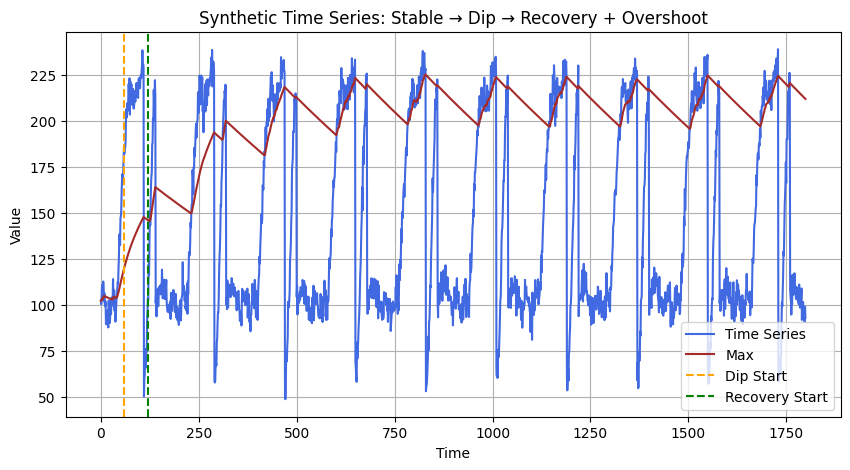

In [163]:
# Algorithm in this cell, rest all cells are data sets which can be run first to populate time series and validate it here.

old_weightage = .999
base_learning = 0.2

max_value = time_series[0]
max_time_series = []
for i, value in enumerate(time_series):

    if i > 60 and value > 1.2 * max_value:
        print(f"Issue at t={i}: value={value:.2f}, breaching upper threshold {1.2 * max_value:.2f}")

    if value > max_value:
        # Compute relative delta
        delta = value - max_value
        rel_delta = abs(delta) / (max_value + 1e-6)

        # Track continuous rise streak
        growth_streak += 1

        # Continuous rise penalty — longer rise = slower learning
        streak_penalty = 1 + 0.075 * growth_streak   # adjust 0.1 for aggressiveness

        # Adaptive learning: large delta or long streak => slower learning
        new_learning = base_learning / ((1 + 10 * rel_delta) * streak_penalty)
        new_learning = np.clip(new_learning, 0.001, base_learning)

        # Update max
        max_value = max_value + (value - max_value) * new_learning

    else:
        # Reset streak if value falls or stagnates
        growth_streak = 0
        # Decay gradually when below max
        max_value = max_value * old_weightage

    max_time_series.append(max_value)

plt.figure(figsize=(10, 5))
plt.plot(time_series, label="Time Series", color='royalblue')
plt.plot(max_time_series, label="Max", color='brown')
plt.axvline(n_per_segment, color='orange', linestyle='--', label="Dip Start")
plt.axvline(2 * n_per_segment, color='green', linestyle='--', label="Recovery Start")
plt.title("Synthetic Time Series: Stable → Dip → Recovery + Overshoot")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

Mean of first segment: 99.69
Std (z-score) of first segment: 1.00


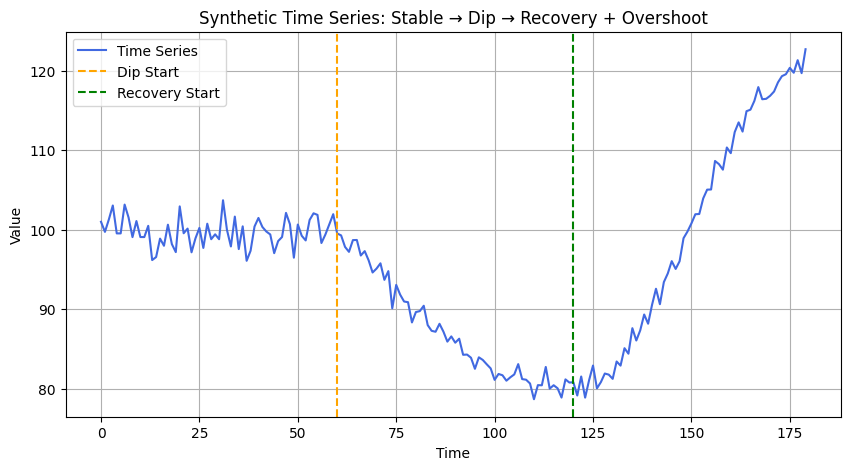

In [150]:
## Random data set having stable period, dip and then increase to break resistance.

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Set seed for reproducibility
np.random.seed(42)

# Parameters
stable_mean = 100
stable_std = 2
dip_depth = 80
overshoot_level = 120   # slightly higher than the first plateau
n_per_segment = 60

# 1️⃣ Stable first 60 points (z-score ≈ 1)
part1 = np.random.normal(stable_mean, stable_std, n_per_segment)

# 2️⃣ Dip phase (smooth downward curve)
x2 = np.linspace(0, np.pi, n_per_segment)
part2 = stable_mean - (stable_mean - dip_depth) * np.sin(x2 / 2) + np.random.normal(0, 1, n_per_segment)

# 3️⃣ Recovery + Overshoot
# We'll make it recover back to stable_mean first, then slightly overshoot
x3 = np.linspace(0, np.pi, n_per_segment)
# recovery curve with overshoot (1.1 multiplier adds the breach)
part3 = dip_depth + (overshoot_level - dip_depth) * (1 - np.cos(x3)) / 2 + np.random.normal(0, 1, n_per_segment)

# Combine the segments
time_series = np.concatenate([part1, part2, part3])

# Compute z-scores for the first segment
zscores = zscore(part1)
print(f"Mean of first segment: {np.mean(part1):.2f}")
print(f"Std (z-score) of first segment: {np.std(zscores):.2f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_series, label="Time Series", color='royalblue')
plt.axvline(n_per_segment, color='orange', linestyle='--', label="Dip Start")
plt.axvline(2 * n_per_segment, color='green', linestyle='--', label="Recovery Start")
plt.title("Synthetic Time Series: Stable → Dip → Recovery + Overshoot")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


🚨 Breach @ t=74: value=151.01 > env=131.66 (+10%)


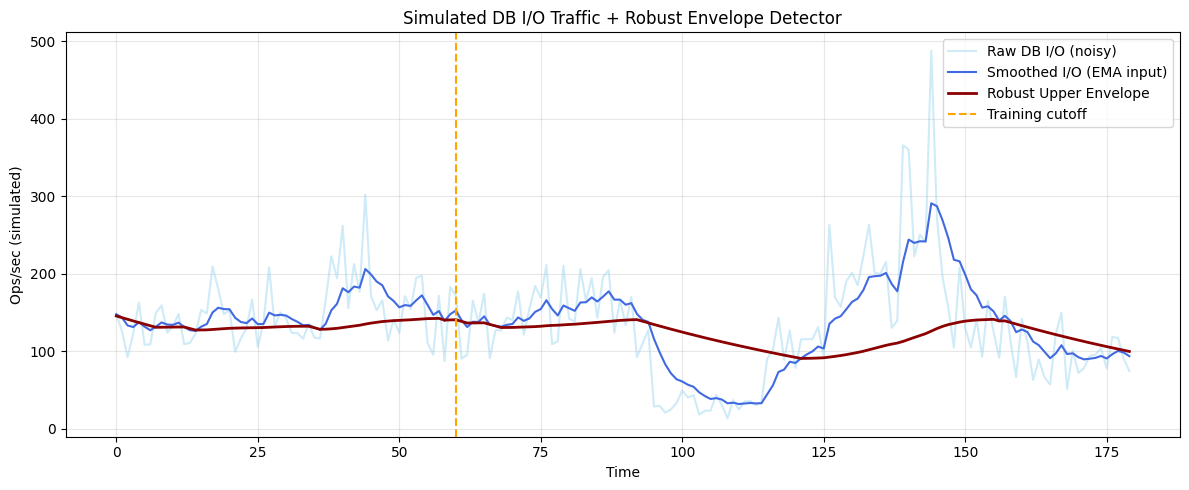

In [158]:
import numpy as np
import matplotlib.pyplot as plt

# --- RANDOM SEED for reproducibility ---
np.random.seed(42)

# ---------- 1) Generate Realistic, Non-Gaussian DB I/O ----------
n = 180
t = np.arange(n, dtype=float)

# Baseline (diurnal-like pattern)
baseline = 120 + 35 * np.sin(2 * np.pi * t / 60)

# Add bursts and dips
def bump(center, width, height):
    return height * np.exp(-0.5 * ((t - center) / width) ** 2)

lam = baseline + bump(45, 6, 100) + bump(140, 8, 90)

# Simulate outage period
lam[(t >= 95) & (t < 115)] *= 0.35

# Poisson arrivals (integer load levels)
counts = np.random.poisson(np.clip(lam, 1, None))

# Add heavy-tailed lognormal multiplicative noise
noise = np.random.lognormal(mean=0.0, sigma=0.25, size=n)

# Final synthetic DB I/O series
time_series = counts * noise

# ---------- 2) Pre-Smoothing to Remove High-Frequency Jitter ----------
alpha_in = 0.2  # lower alpha = smoother input
smoothed_series = np.empty(n)
ema = time_series[0]
for i, v in enumerate(time_series):
    ema = alpha_in * v + (1 - alpha_in) * ema
    smoothed_series[i] = ema

# ---------- 3) Robust Upper Envelope Detector ----------
rise_weight     = 0.98   # responsiveness to rising values (lower = faster)
decay_weight    = 0.985  # responsiveness to falling values (closer to 1 = slower decay)
margin_up       = 0.10   # 10% breach threshold
hysteresis_down = 0.05   # 5% hysteresis band to prevent double-counting
refractory      = 6      # steps to wait before next alert
train_cutoff    = 60     # first N points used for "training"

upper_env_val = smoothed_series[0]
upper_env_series = []
cooldown = 0
armed = True  # hysteresis flag

for i, value in enumerate(smoothed_series):
    # detect breach after training phase
    if i > train_cutoff and armed and value > (1 + margin_up) * upper_env_val and cooldown == 0:
        print(f"🚨 Breach @ t={i}: value={value:.2f} > env={upper_env_val:.2f} (+{margin_up*100:.0f}%)")
        cooldown = refractory
        armed = False

    # re-arm the detector once signal returns close to the envelope
    if not armed and value < (1 + hysteresis_down) * upper_env_val:
        armed = True

    # envelope update
    if value > upper_env_val:
        # move up slowly (noise-resistant)
        upper_env_val = rise_weight * upper_env_val + (1 - rise_weight) * value
    else:
        # decay slowly (trend-following)
        upper_env_val = decay_weight * upper_env_val

    upper_env_series.append(upper_env_val)
    if (cooldown > 1):
      cooldown = cooldown - 1

upper_env_series = np.array(upper_env_series)

# ---------- 4) Visualization ----------
plt.figure(figsize=(12, 5))
plt.plot(time_series, label="Raw DB I/O (noisy)", color='skyblue', alpha=0.4)
plt.plot(smoothed_series, label="Smoothed I/O (EMA input)", color='royalblue', linewidth=1.5)
plt.plot(upper_env_series, label="Robust Upper Envelope", color='darkred', linewidth=2)
plt.axvline(train_cutoff, color='orange', linestyle='--', label="Training cutoff")
plt.title("Simulated DB I/O Traffic + Robust Envelope Detector")
plt.xlabel("Time")
plt.ylabel("Ops/sec (simulated)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


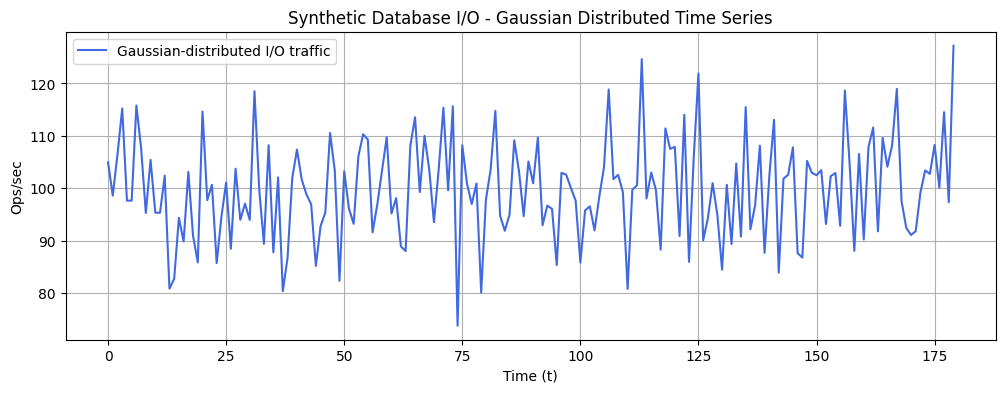

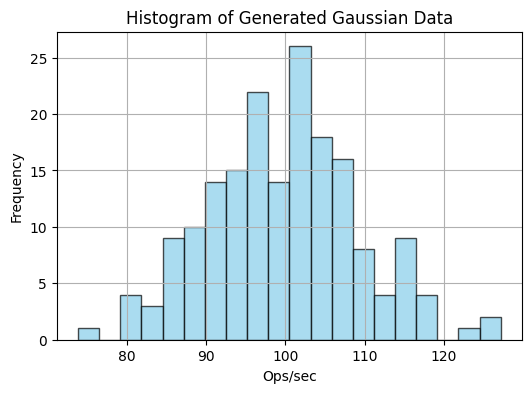

In [160]:
### Gaussian

import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters for Gaussian distribution
n_points = 180        # number of data points
mean = 100            # central value (e.g. avg DB I/O ops/sec)
std_dev = 10          # standard deviation (spread of values)

# Generate Gaussian-distributed data
time_series = np.random.normal(loc=mean, scale=std_dev, size=n_points)

# Plot the time series
plt.figure(figsize=(12, 4))
plt.plot(time_series, color='royalblue', label='Gaussian-distributed I/O traffic')
plt.title("Synthetic Database I/O - Gaussian Distributed Time Series")
plt.xlabel("Time (t)")
plt.ylabel("Ops/sec")
plt.grid(True)
plt.legend()
plt.show()

# Also visualize its histogram
plt.figure(figsize=(6, 4))
plt.hist(time_series, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Generated Gaussian Data")
plt.xlabel("Ops/sec")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


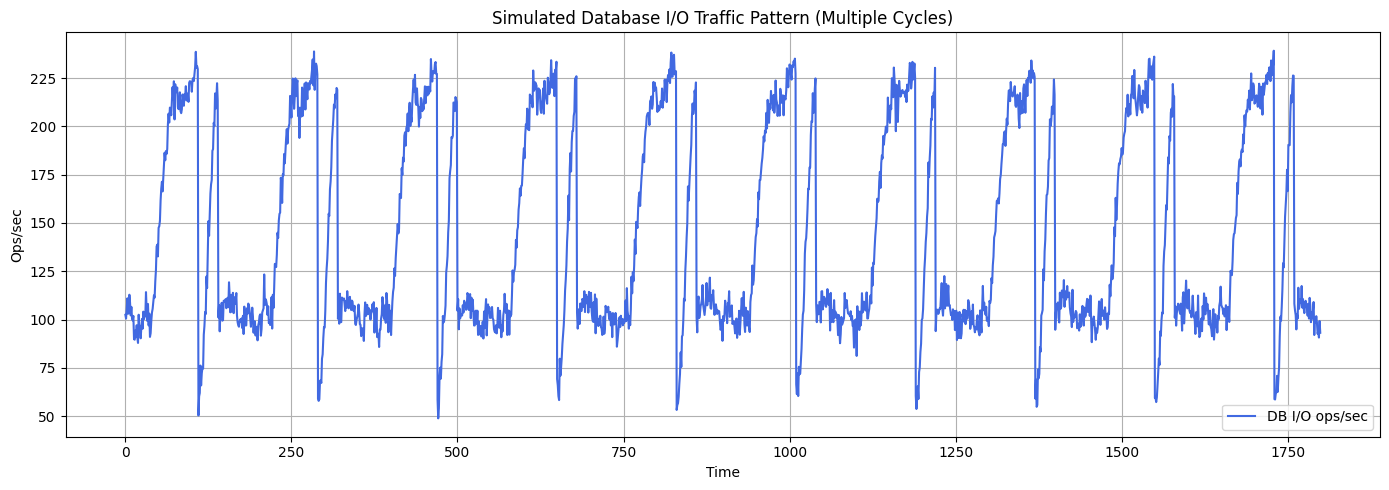

In [162]:
# --- Simulated DB Traffic Pattern ---

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

n_points = 180
time = np.arange(n_points)

# --- Define different phases ---
normal_base = 100
peak_base = 220
drop_base = 60

# Simulate multiple cycles (e.g., 10 rounds of 180 points each)
num_cycles = 10
time_series = []

for cycle in range(num_cycles):
    for t in time:
        # Segment definitions
        if t < 40:
            # Normal traffic
            mean = normal_base + 5 * np.sin(t / 4)
        elif t < 80:
            # Gradual increase toward peak
            mean = normal_base + (peak_base - normal_base) * np.sin((t - 40) / 40 * np.pi / 2)
        elif t < 110:
            # High load peak
            mean = peak_base - 10 * np.cos((t - 80) / 30 * np.pi)
        elif t < 140:
            # Drop phase (outage or maintenance)
            mean = drop_base + (peak_base - drop_base) * (1 - np.cos((t - 110) / 30 * np.pi)) / 2
        else:
            # Recovery back to normal
            mean = normal_base + 10 * np.sin((t - 140) / 10)

        # Add realistic jitter (noise)
        value = mean + np.random.normal(0, 5)
        time_series.append(value)

time_series = np.array(time_series)
full_time = np.arange(len(time_series))

# --- Plot ---
plt.figure(figsize=(14, 5))
plt.plot(full_time, time_series, color='royalblue', label='DB I/O ops/sec')
plt.title("Simulated Database I/O Traffic Pattern (Multiple Cycles)")
plt.xlabel("Time")
plt.ylabel("Ops/sec")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
